In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = "ffnn_wmse"

## 1) Aggregate all results

In [2]:
all_data = []
model_summary = []
idx = 0
for model_tag in tqdm([MODEL_TAGS],
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp, index=[idx]))
            idx += 1
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)

# aggregate relevant metrics
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()
wmse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.wmse_melt).reset_index()

# summary mse
hist_mse = mse_group_df.loc[mse_group_df["model"]==MODEL_TAGS][["mse"]]
hist_mse.rename(columns={"mse": MODEL_TAGS + " mse"}, inplace=True)
hist_mse_df = hist_mse.copy().reset_index(drop=True)

# summary wmse
hist_wmse = wmse_group_df.loc[wmse_group_df["model"]==MODEL_TAGS][["wmse"]]
hist_wmse.rename(columns={"wmse": MODEL_TAGS + " wmse"}, inplace=True)
hist_wmse_df = hist_wmse.copy().reset_index(drop=True)

# summary mae
hist_mae = mae_group_df.loc[mae_group_df["model"]==MODEL_TAGS][["mae"]]
hist_mae.rename(columns={"mae": MODEL_TAGS + " mae"}, inplace=True)
hist_mae_df = hist_mae.copy().reset_index(drop=True)

Append all model results: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

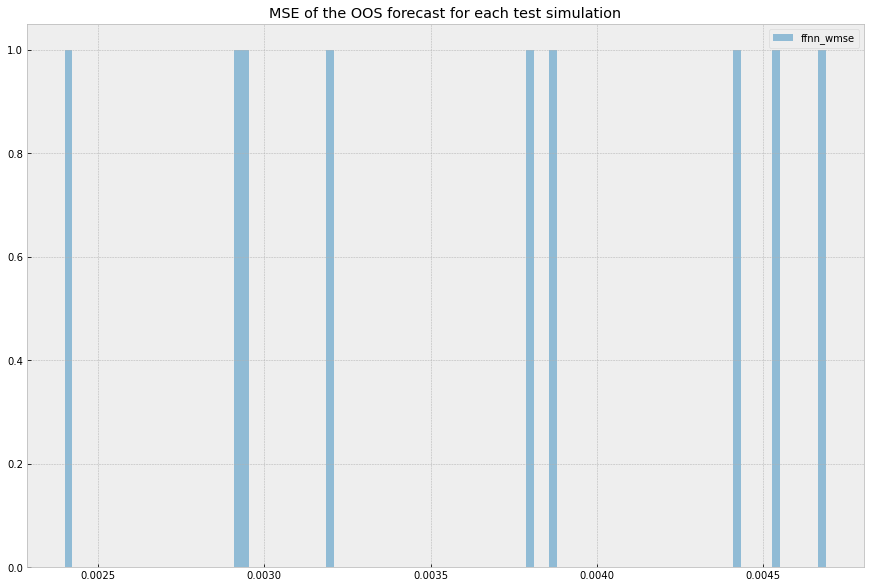

In [3]:
bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label=MODEL_TAGS)
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

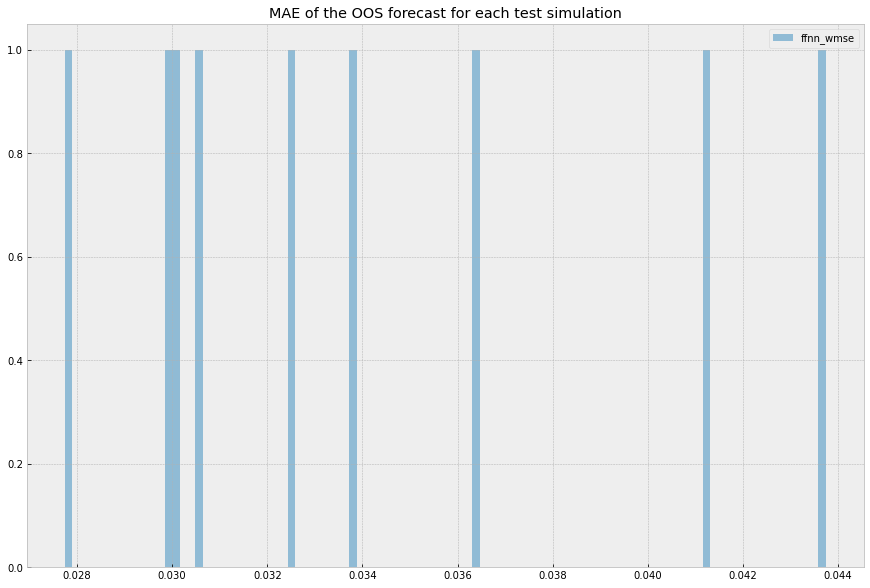

In [4]:
bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label=MODEL_TAGS)
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

### WMSE histogram

Text(0.5, 1.0, 'WMSE of the OOS forecast for each test simulation')

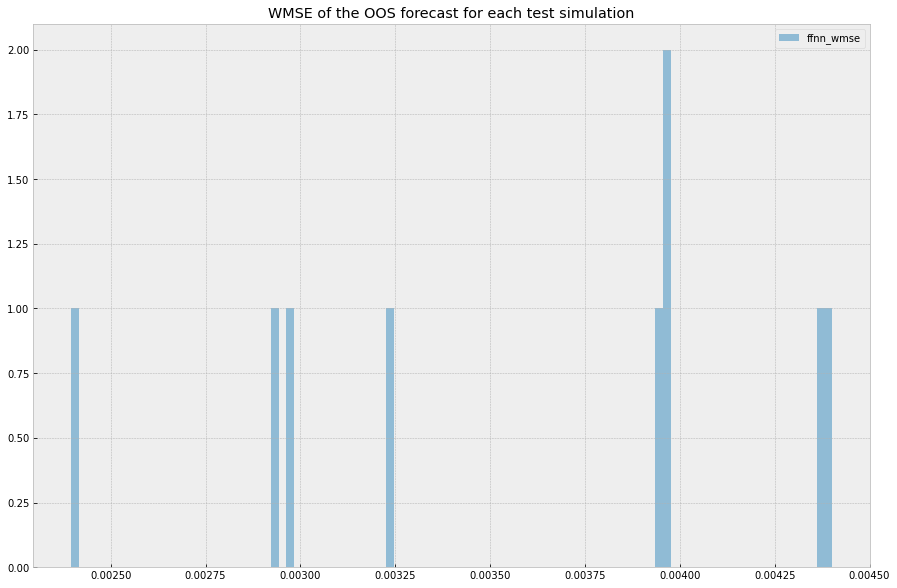

In [7]:
bins = np.linspace(hist_wmse_df.min().min(), hist_wmse_df.max().max(), 100)
plt.hist(hist_wmse_df[hist_wmse_df.columns[0]], bins, alpha=0.5, label=MODEL_TAGS)
plt.legend(loc='upper right')
plt.title("WMSE of the OOS forecast for each test simulation")